# Training a Quadcopter : How to Fly

Training a quadcopter to take off using ***Actor-Critic*** approach based ***DDPG*** algorithm.

## Controlling the Quadcopter

Lets look at a much more simpler learning agent to get a better sense of the problem. This is defined in `agents/policy_search.py`

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

Later, the agent implemented using DDPG approach in `agents/agent.py` will have a far more intelligent method for selecting actions!

In [1]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [2]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

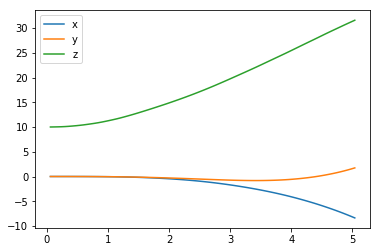

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

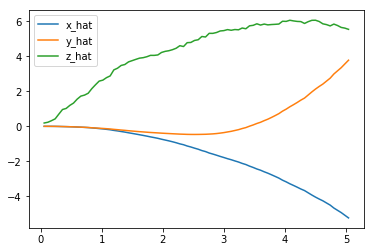

In [4]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

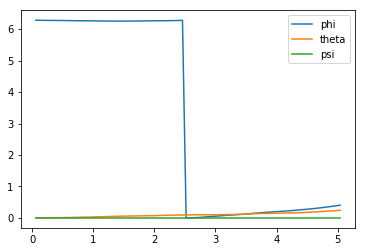

In [5]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

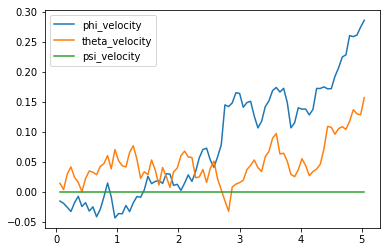

In [6]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

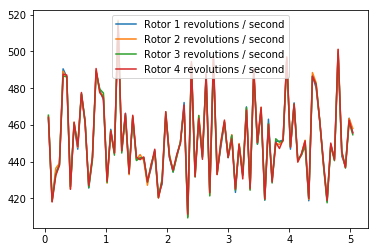

In [7]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [8]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[-8.3706922   1.73741554 31.58276078  0.40416693  0.24192162  0.        ]
[-5.23543141  3.77955149  5.5438279 ]
[0.28597958 0.15725296 0.        ]


## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [16]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 1000
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode = 1000, score =  -5.938 (best =   2.047), noise_scale = 3.25

This agent should perform very poorly on this task.

## Task

Though we can select from a range of different tasks for the quadcopter, in this notebook we want the agent to learn to take-off. The task is defined in `task.py`. Remember that depending on how we formulate the reward function, the nature of our task and agents ability to learn it efficienty will change.

Though there is a separate field called **Inverse Reinforcement learning** that explores the best reward function to be used for a given task, here the reward function was designed using trial and error and using common sense in order to ensure that our reward function encourages the quadcopter to take-off in a smooth fashion.

In [136]:
## Training the RL agent

from agents.agent import DDPG
from task import Task
# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# defining initial state variables and target for the quad to rise up to
target_pos = np.array([0., 0., 80.])
init_pos = np.array([0.,0.,30.,0.,0.,0.])

# defining the task i.e to take off
task = Task(init_pose=init_pos,target_pos=target_pos)

# RL agent
rl_agent = DDPG(task,prioritised_replay=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.
INFO:tensorflow:Scale of 0 disables regularizer.


In [137]:
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'
%matplotlib inline

# train function for the RL agent
def train(agent,max_num_episodes=10000,DISPLAY_STEP = 100):
        
        # getting timestamp
        timestamp = str(int(time.time()))

        # log_path for tensorboard
        LOGS_PATH = "./tensorboard/"+timestamp
        
        with tf.Session() as sess:
            # initialize all variables
            sess.run(tf.global_variables_initializer())
            
            # create log writer object
            train_writer = tf.summary.FileWriter(LOGS_PATH+'/train',sess.graph)
            
            # Set same weights for target and local models
            sess.run(agent.target_update_ops,feed_dict={agent.tau:1.0})
            max_reward = -10000
            
            
            for eps_count in range(max_num_episodes):
                # reset agent
                agent.reset()
                total_reward,episode_step = 0,0
                x,y,z,rotor_speed = [],[],[],[]
                
                while True:
                    # record x,y,z values for later analysis
                    x.append(agent.last_state[0])
                    y.append(agent.last_state[1])
                    z.append(agent.last_state[2])
                    
                    # choose action using epsilon greedy policy
                    action = agent.act(sess,agent.last_state)
                    
                    # saving actions taken by the quad
                    rotor_speed.append(action)
                    
                    # taking the next step in the env using the above action
                    next_state,reward,done = agent.task.step(action)
                    agent.step(sess,action, reward, next_state, done)
                    
                    # updating total reward and time-step of the episode
                    total_reward += reward
                    episode_step += 1
                    
                    
                    if done or episode_step == 200:
                        # showing learning progress
                        rotor_speed = np.array(rotor_speed)
                        max_reward = max(max_reward,total_reward)
                        if eps_count % DISPLAY_STEP == 0:
                            print ("episode : {} ... total reward :{} ... max reward :{} ... eps_length : {}"
                                   .format(eps_count,total_reward,max_reward,episode_step))
                        
                        if eps_count % 50 == 0 :
                            # plotting x,y,z trajectories and rotor speeds for the episode
                            fig, ax = plt.subplots(nrows=1, ncols=2,figsize=[15,5])
                            t = range(len(z))
                            ax[0].plot(t,z,label='z')
                            ax[0].plot(t,x,label='x')
                            ax[0].plot(t,y,label='y')
                            ax[0].set_ylim([-5,150])
                            ax[0].set_xlim([-10,100])
                            ax[0].legend()
                            ax[0].set_title('eps_count : '+ str(eps_count))
                            z_ticks = np.arange(0, 140 , 10)
                            ax[0].set_yticks(z_ticks)
                            ax[0].grid()
                            ax[1].plot(t,rotor_speed[:,0],label="r1")
                            ax[1].plot(t,rotor_speed[:,1],label="r2")
                            ax[1].plot(t,rotor_speed[:,2],label="r3")
                            ax[1].plot(t,rotor_speed[:,3],label="r4")
                            ax[1].set_ylim([-100,1000])
                            ax[1].set_xlim([-10,100])
                            ax[1].legend()
                            s_ticks = np.arange(0, 1000, 100)
                            ax[1].set_yticks(s_ticks)
                            ax[1].grid()
                            plt.show()
                        
                        # saving tensorflow summary for visualisation using tensorboard
                        summary = sess.run(agent.summary_op,feed_dict={agent.reward_log:total_reward,agent.eps_length_log:episode_step})
                        train_writer.add_summary(summary, eps_count)
                        break

episode : 0 ... total reward :71.43665186467648 ... max reward :71.43665186467648 ... eps_length : 57


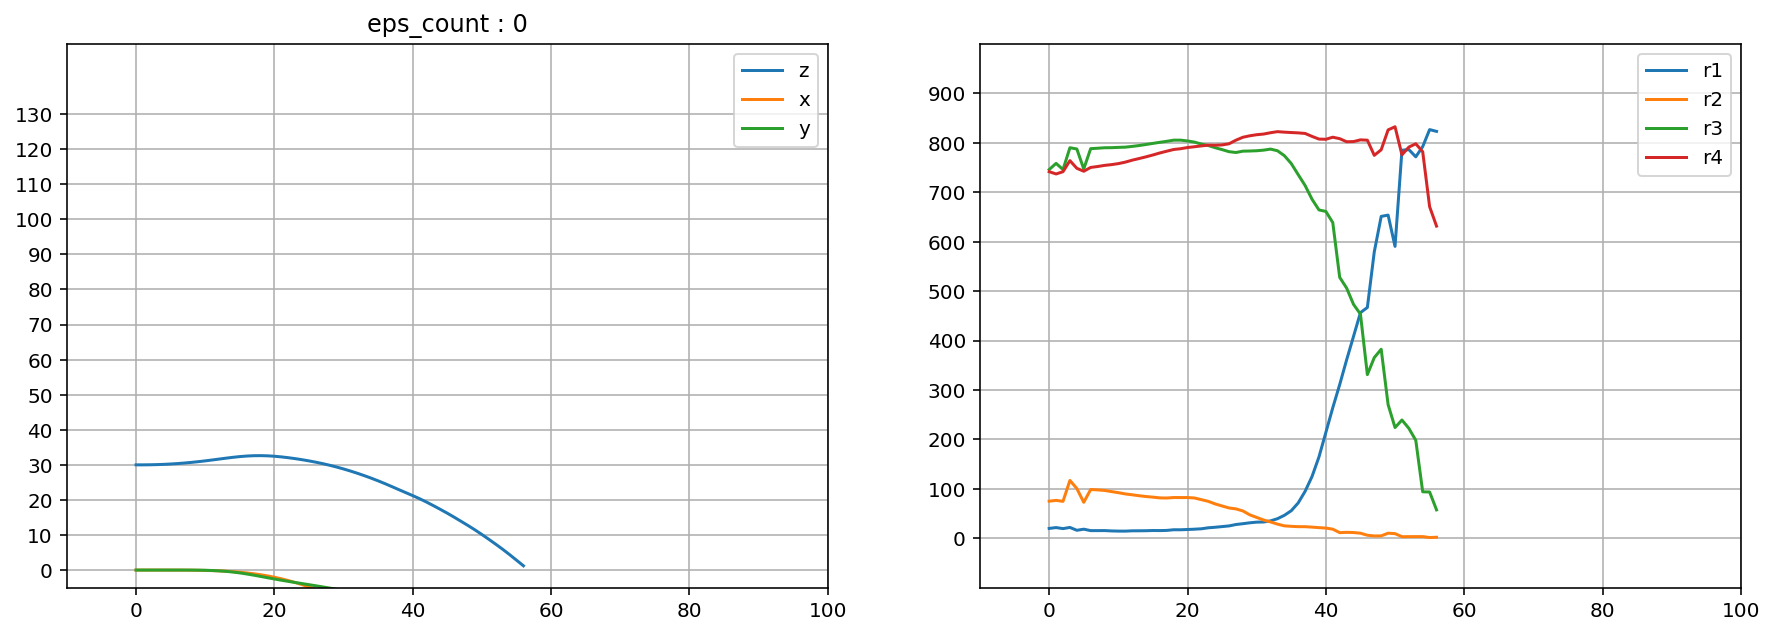

/home/jsingh/learning/RL_quadcopter/physics_sim.py:114: RuntimeWarning: divide by zero encountered in double_scalars
  J = V / n * D
/home/jsingh/learning/RL_quadcopter/physics_sim.py:114: RuntimeWarning: invalid value encountered in double_scalars
  J = V / n * D


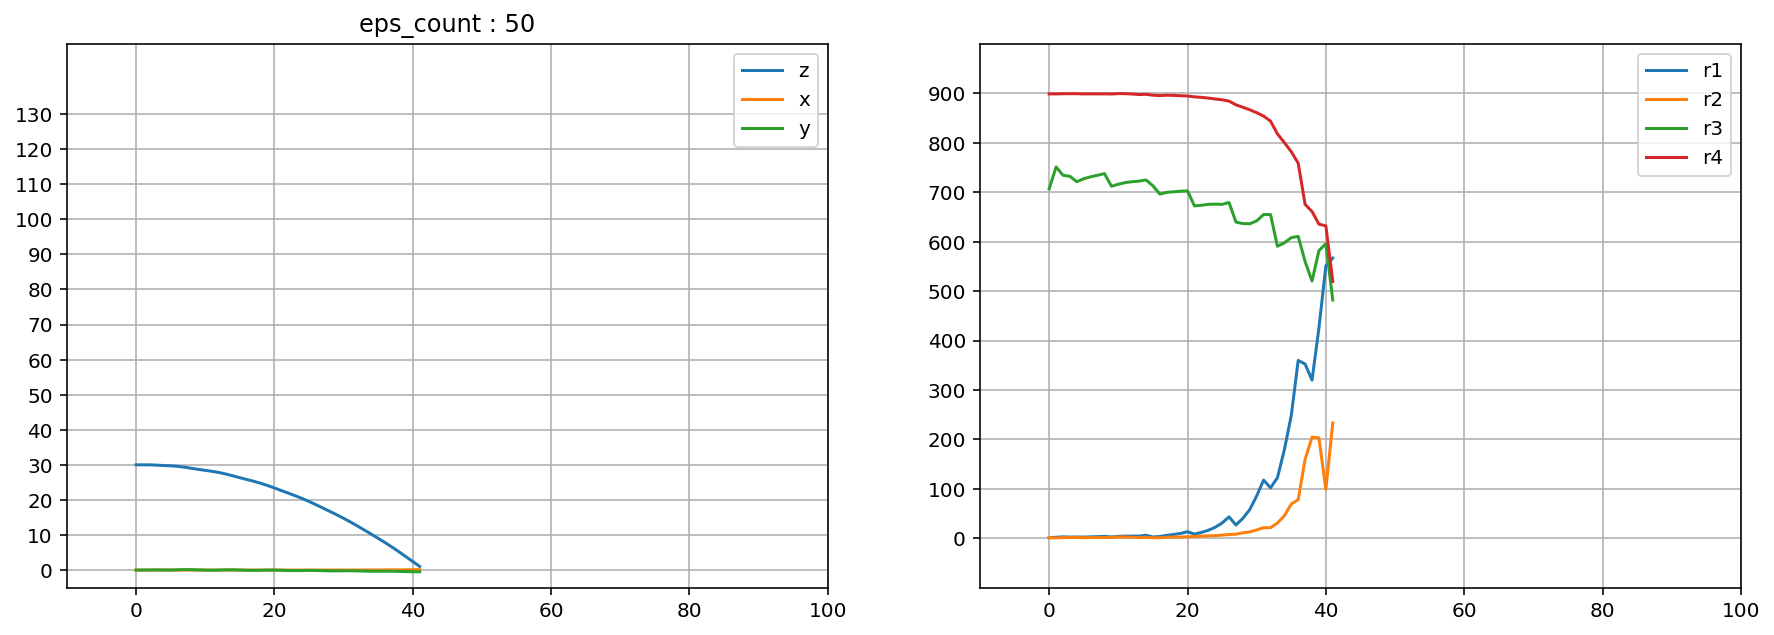

episode : 100 ... total reward :49.395089902853485 ... max reward :173.09602057248946 ... eps_length : 42


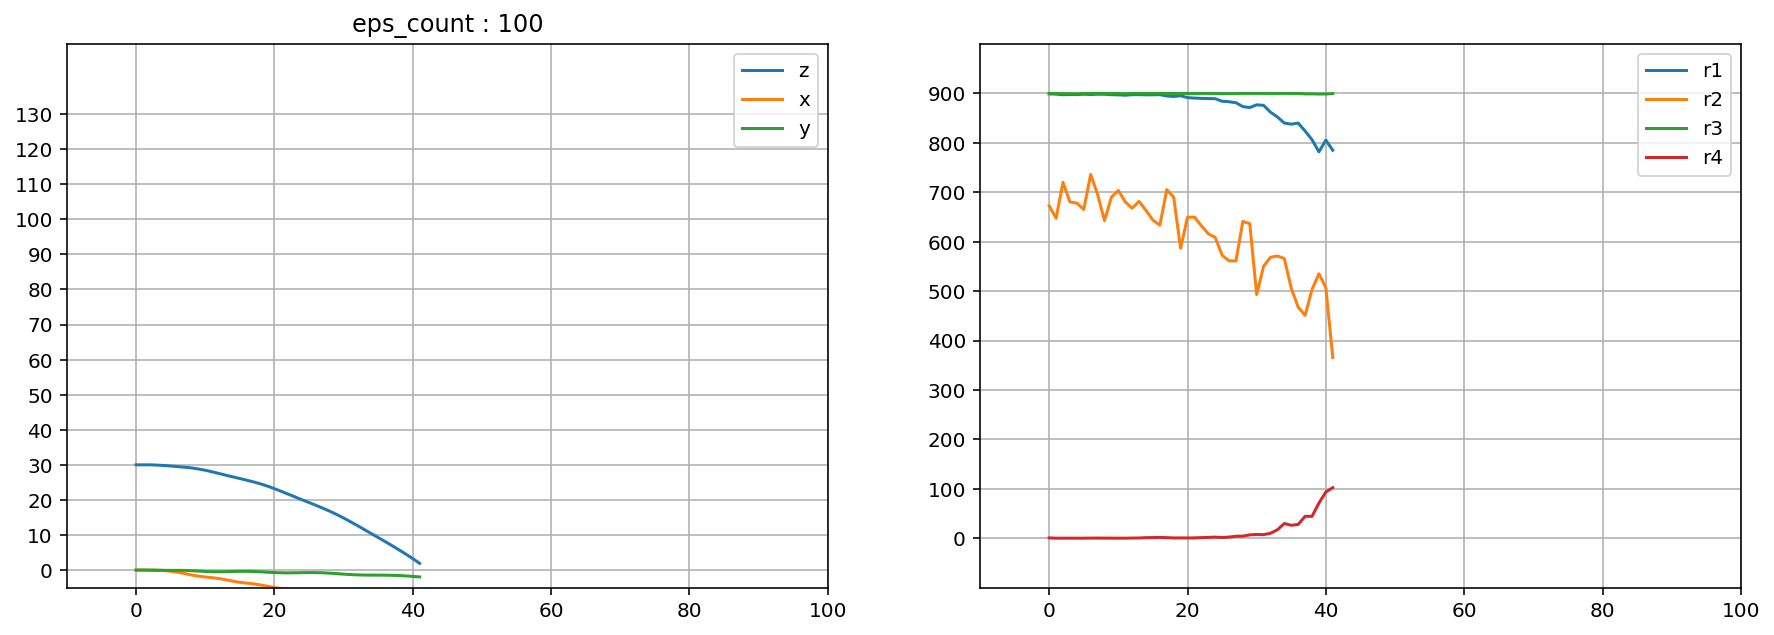

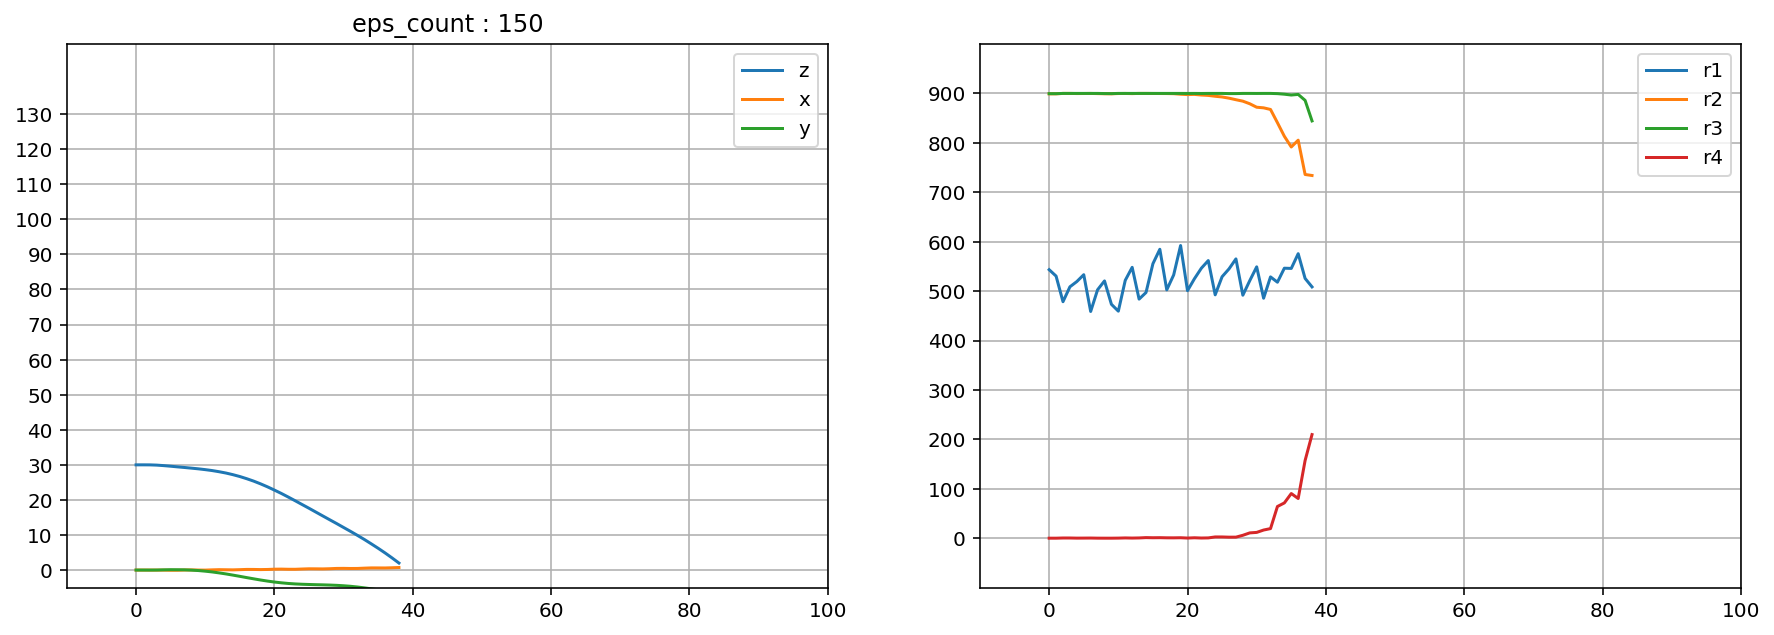

episode : 200 ... total reward :50.843397148676864 ... max reward :173.09602057248946 ... eps_length : 43


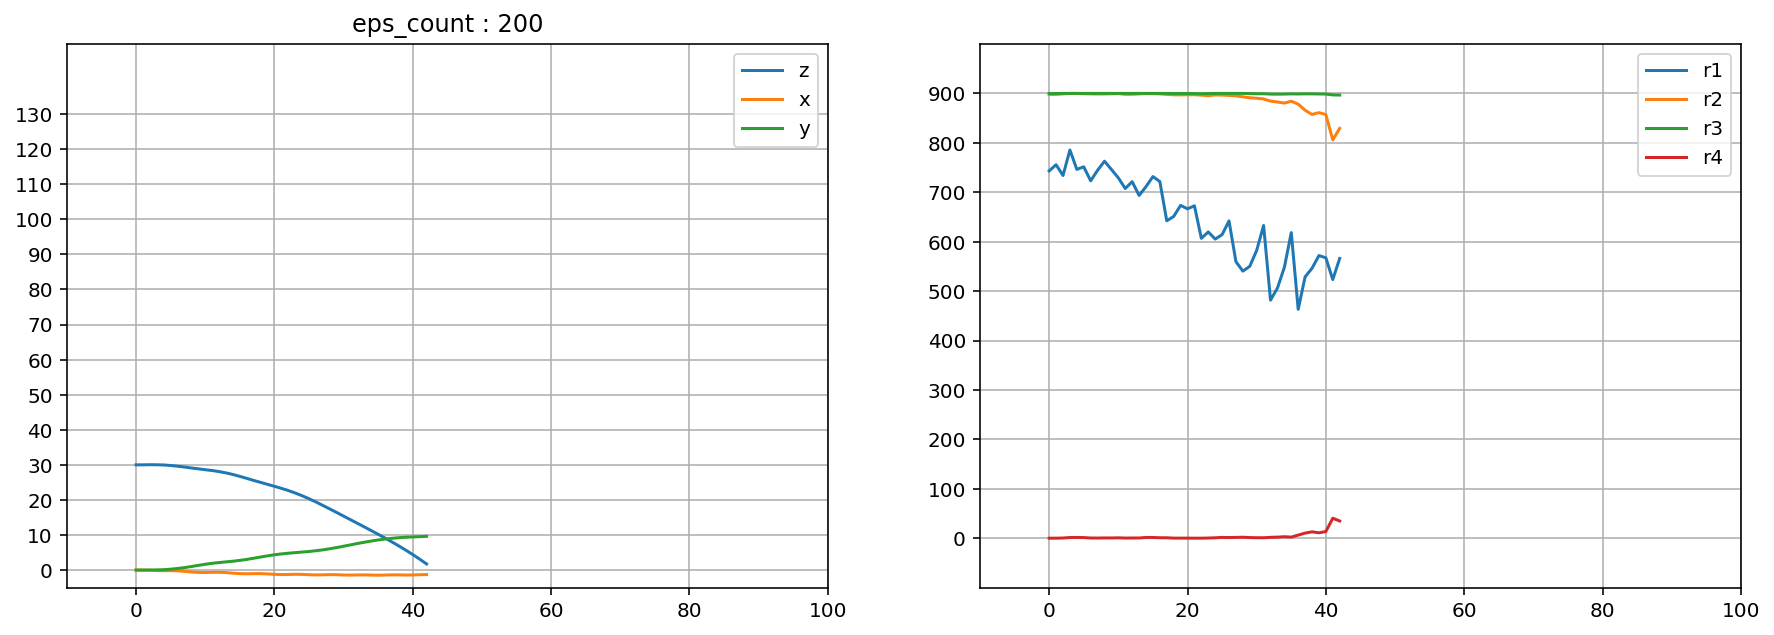

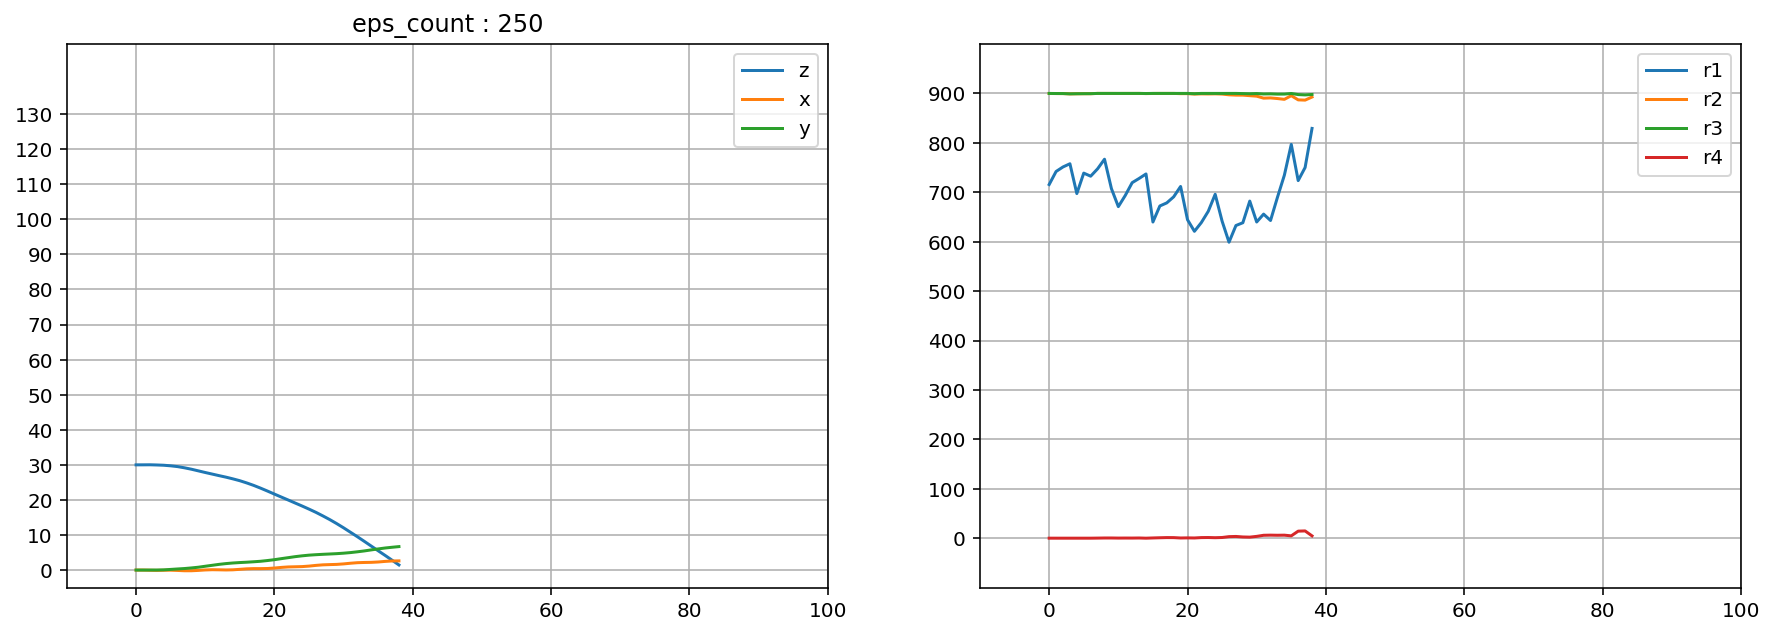

episode : 300 ... total reward :83.77254115845528 ... max reward :173.09602057248946 ... eps_length : 64


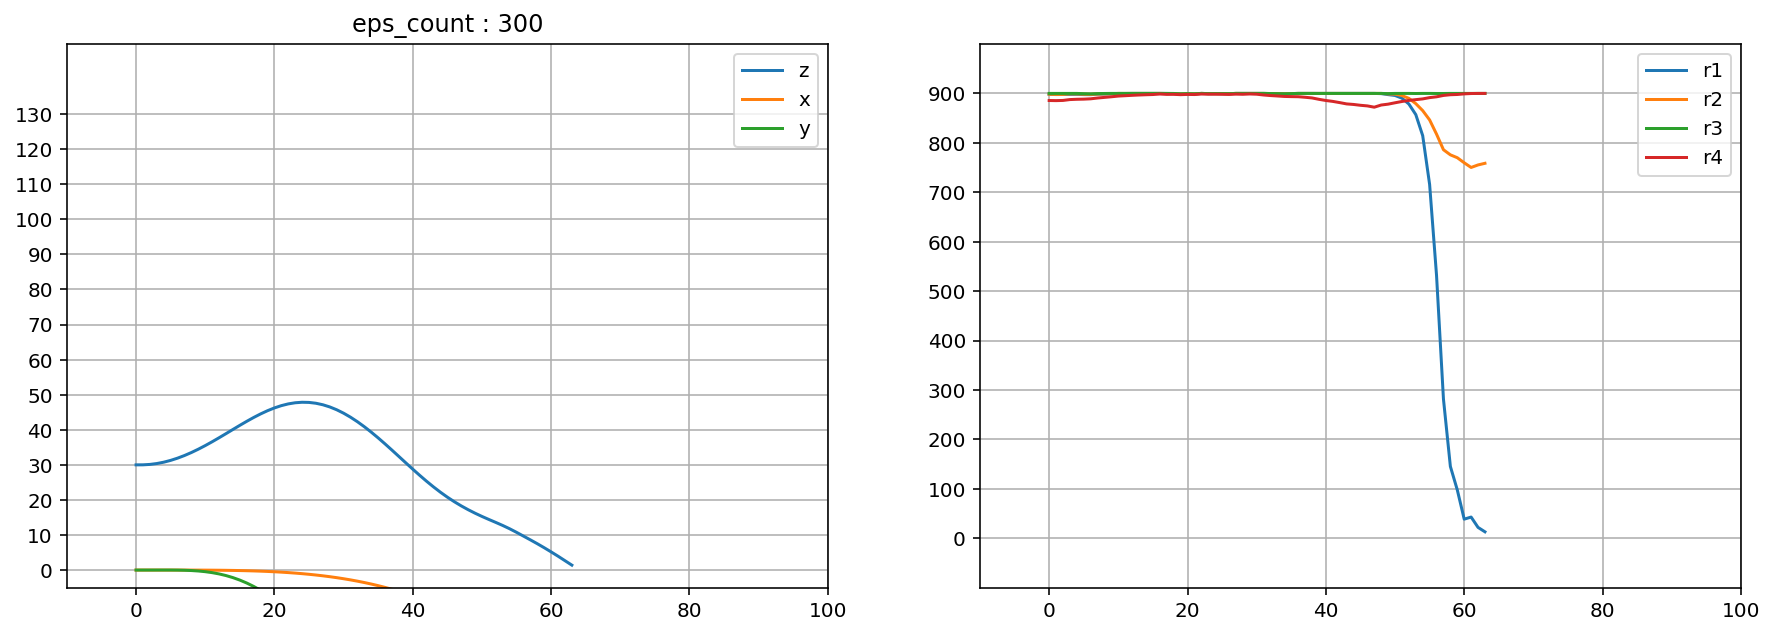

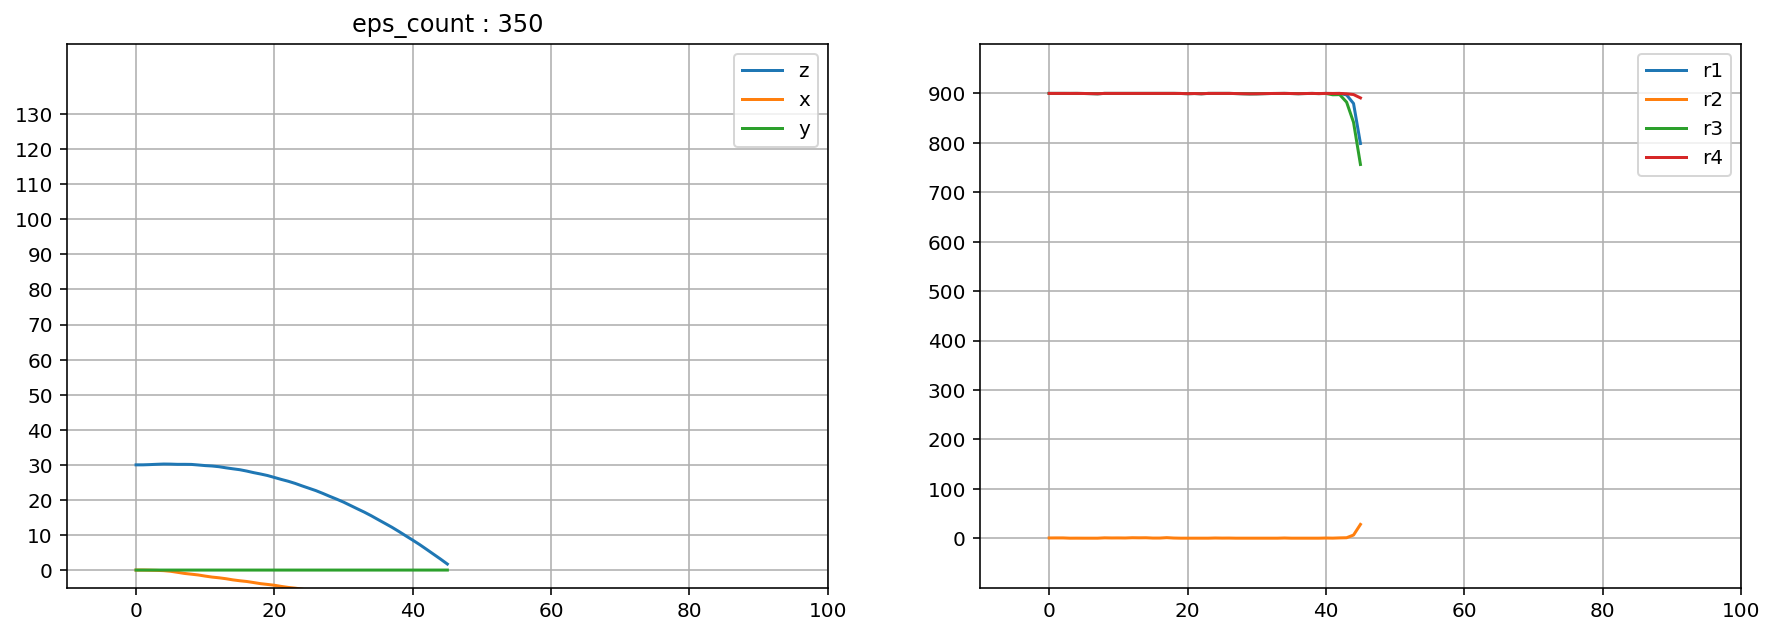

episode : 400 ... total reward :100.21911501655555 ... max reward :173.09602057248946 ... eps_length : 84


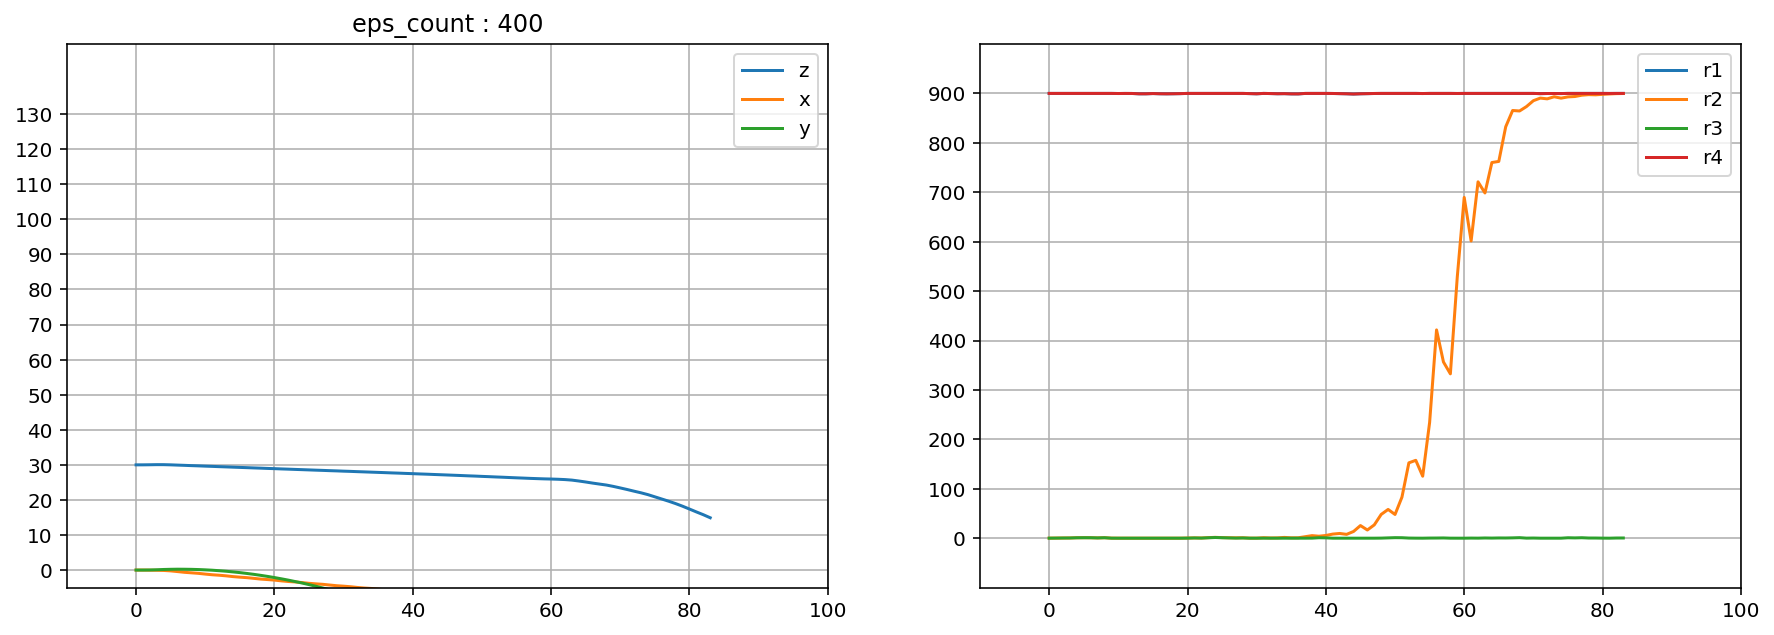

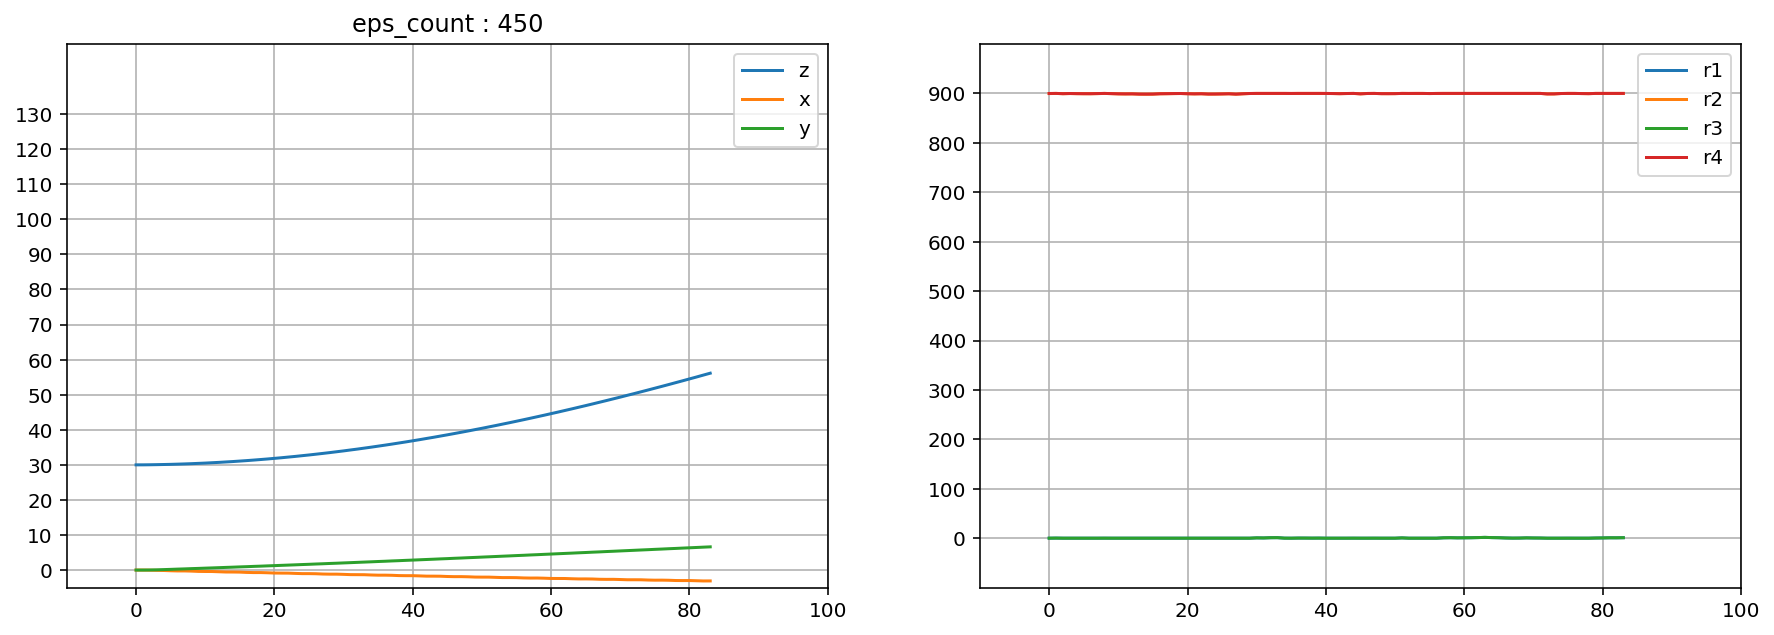

episode : 500 ... total reward :150.41726357332172 ... max reward :173.09602057248946 ... eps_length : 84


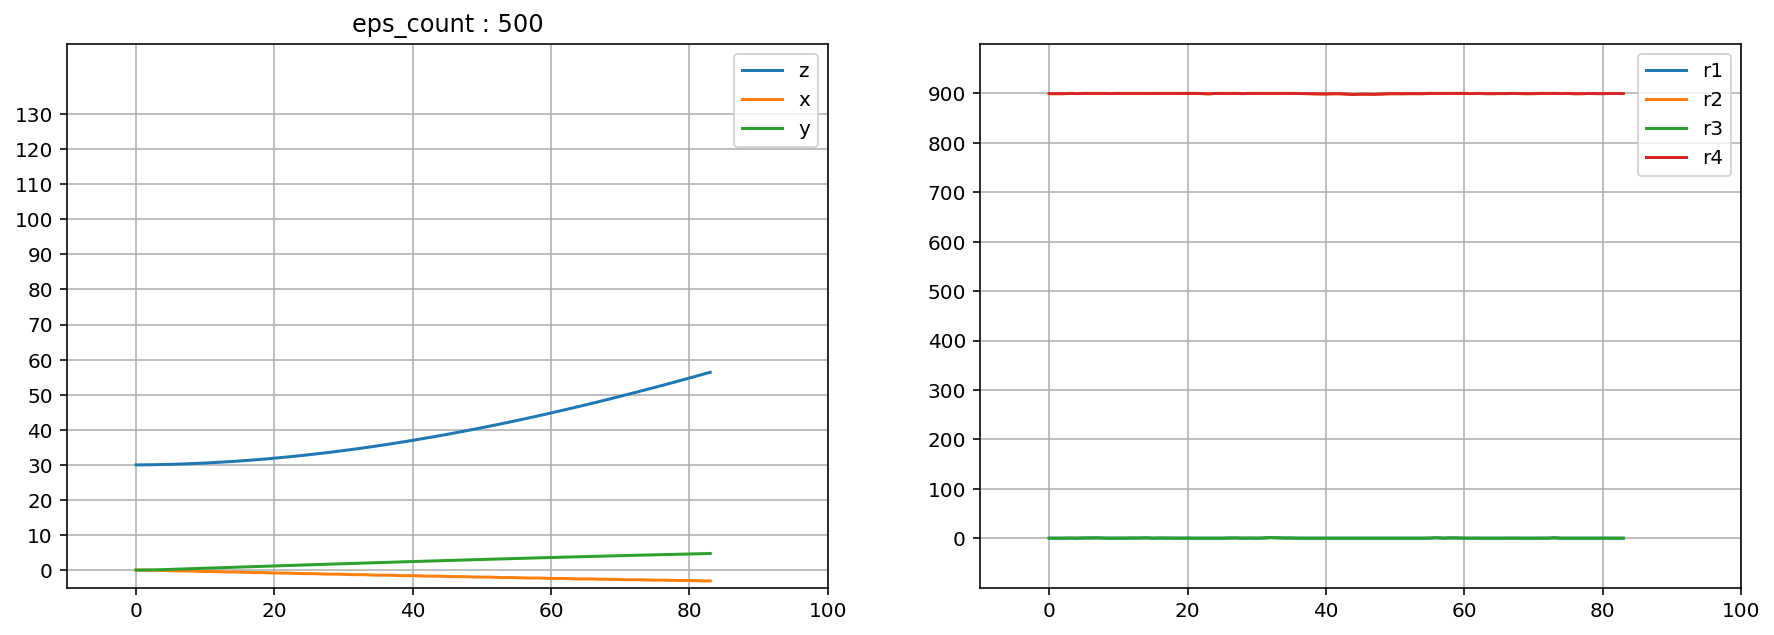

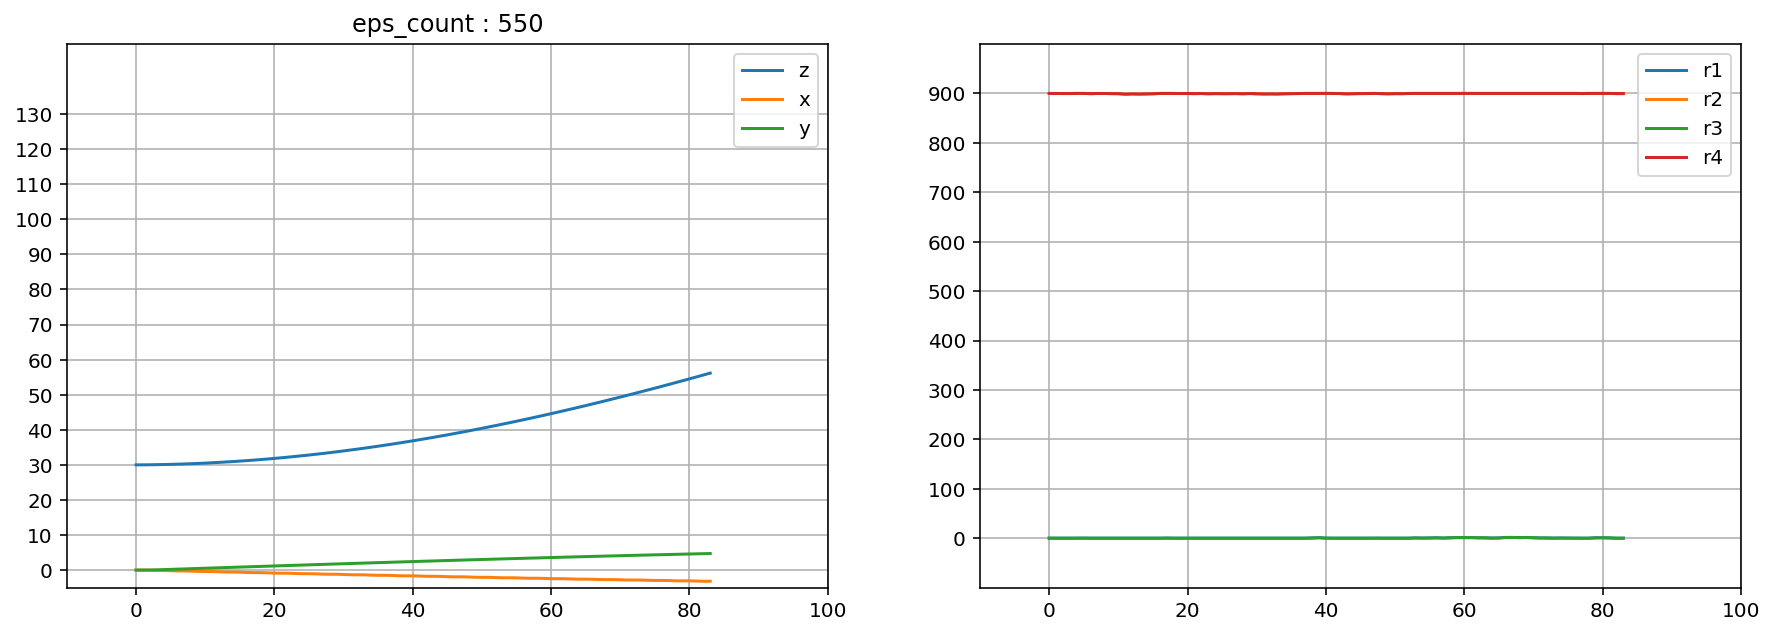

episode : 600 ... total reward :150.24933258560952 ... max reward :173.09602057248946 ... eps_length : 84


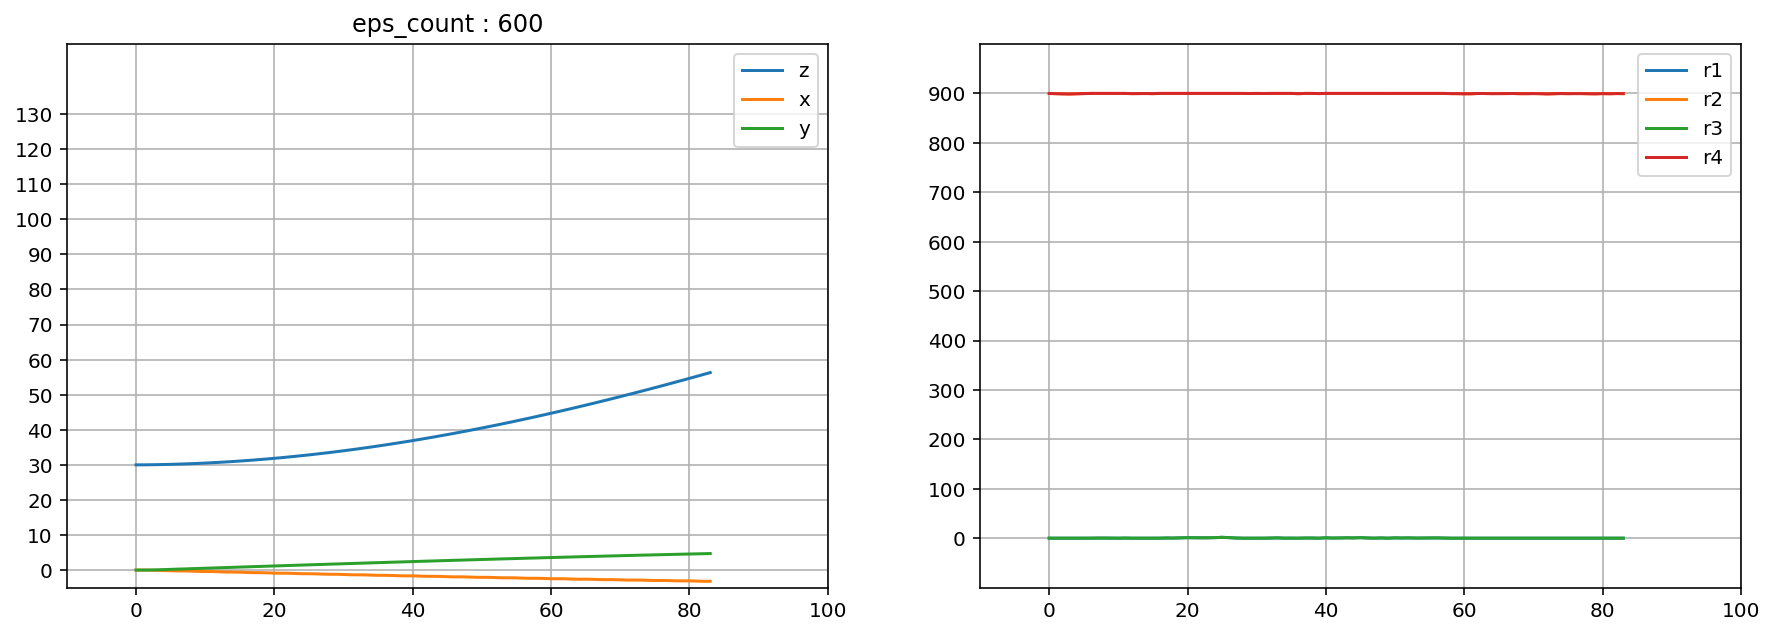

KeyboardInterrupt: 

In [138]:
_ = train(rl_agent)

## Reward plot

Though the rewards should ideally be visualised using tensorboard (see the train function), here is how it looks like.

<img src="rewards.png">

## Reflections


### Designing task and the reward function

* The agent is being trained for a takeoff task, which means the agent has to learn to fly above from its starting position to reach a target position. 


* I experimented with a number of reward functions which might force the agent to stay upright , avoid swinging around etc. However , as far as my experimentation goes a simple reward function with a negative L2 distance between current and target position works the best so far.(However, I am inclined to think that a those restrictions should help).


* Another important part of the reward function is a penalty term for going out of bounds(e.g hitting the ground) before a certain number of steps.This is essential because without this penalty term , the agent sometimes learns that ending the episode earlier (in order to cut-down the negative rewards for not reaching the target position) might be the best approach. 

\begin{equation}
Possible \ Reward \ function = penalty + 1.0 - .03 * (\text{L2 norm of the difference between target pos and current pos})
\end{equation}

for my reward function , penalty = -10 if episode ends before 240 timesteps.

* However I later found out that the penalty is not required if the agent is mostly rewarded positively for not going out of bounds. So for my specific initial and target position pair , the following reward function worked the best for me.

\begin{equation}
Final \ Reward \ function = 1.0 - .01 * (\text{L2 norm of the difference between target pos and current pos})
\end{equation}

### Learning Algorithm, Network Architecture and choice of hyperparameters

* The agent is based on the Deep Deterministic Policy Gradients(DDPG) model with a **prioritised experience replay**.It has an actor model which learns the policy used to decide which action to take based on the input state , and a critic model that evaluates the policy learnt by the actor model.


* Following is the choice of hyperparameters used by the model:
    - exploration_mu = 0
    - exploration_theta = .3 (increasing noise too much leads to unstable oscillating rotor speeds)
    - exploration_sigma = .4
    - buffer size = 100000  (tried reducing it to 10000 but the results get worse)
    - batch size = 64
    - gamma = .99
    
    Though the above hyperparameters are important , tuning these was not the hardest part.
 

* 

    **Actor Model**
        - [Fully connected , dim = 128 , BATCH NORM , RELU , DROPOUT] x 3
        - Fully connected ,  dim = action size , activation = sigmoid
        - Scale actions from [0,1] --> (action.low,action.high)
        
    **Critic Model**
        - States : [Fully connected , dim = 128 , BATCH NORM , RELU , DROPOUT] x 2
        - Actions : [Fully connected , dim = 128 , BATCH NORM , RELU , DROPOUT] x 2
        - Add(actions,states)
        - [Fully connected , dim = 128 , BATCH NORM , RELU , DROPOUT] x 2
        - Fully connected ,  dim = 1 , activation = None --> Q(state,action)

* However the most important part was to realise the need of **prioritised experience replay**. The need for prioritised experience replay increases many folds specially in tasks like these , where the exploration of high reward policies might be restricted by the stability issues of the agent.

### Comments on the learning curve

* My first intuition was that it should be an easy task , however as it turns out the stability issues of the quad make it into a 2 fold task : to stay afloat , and rise up to the target position.

* Even if we consider the stability problem to be solved : using single rotor control (same speed and noise for all rotors) , in order to effectively solve the task the agent has to learn to rise with high acceleration and then drop rotor speeds to deaccelerate to maximise reward. However the agent seemed to be struggling to learn this trick in reasonable episodes(though it learnt to rise to the target position fairly quickly). You can try single rotor control by : 
`rl_agent = DDPG(task,single_rotor_control=True , prioritised_replay=True)`

* It was an aha moment. However the trend was observed in most of my experiments including the **Pendulum-v0** gym environment. The reason for this is unclear to me yet. However , as is clear from the visualisations of the training code the agent sometimes goes to-fro between policies before suddenly getting on to the optimum policy. Such behaviour is understandable but I expected it to be more gradual.

* The final performance is OK , with reward of ~ 150

### Difficulties faced and final agent behaviour 

* The hardest part was tuning the reward function to prevent it from falling down , adding penalties and so on.
* The quad somehow learns that it is best to almost turn off two diagonally opposite rotors , while giving thrust for
 the other two rotors(which is kinematically viable).This was odd for me , which prompted me to use a stronger dropout , however most of the times it converged to a similar policy.